In [14]:
### ----- Imports ----- ###

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os.path
import os
import shutil
import glob
import h5py
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from scipy import stats

dataset = 'v1b'

In [15]:
### ----- Parameters ----- ###

# Where to save the products
models_figs_path = '/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/'

# MLAAPDE/data generation params
sr = 20 # Sampling rate
trim_sec = 60 # Trimming amount around phase pick to get from MLAAPDE
trim_pre_sec = trim_sec
trim_post_sec = trim_pre_sec
window_len = trim_pre_sec + trim_post_sec
n_channels = 3 # Instrument channels
cut_lens = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
cut_lens_finish = [70, 80, 90, 100, 110, 120]
cut_lens_test = [7]
desired_shift = 3
max_shift = desired_shift * 2 # Since the shifting method actually makes it half what this value is set to
min_snr_db = False
max_snr_db = False
log_progress_fraction = 100
valid_phases = ['P', 'Pn', 'Pg']
cast_dtype = np.float32

# Training/model params
epochs_number = 200
batch_size = int(256) # Reducing to help memory
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

# Used if loading a trained model
training_dataset = 'v1b'
shift_status = 'shifted'
model_folder_path = '/home/sdybing/mlaapde/training/'

# To make end error plots
mean_errors = []
median_errors = []
std_errors = []

In [16]:
### ----- Load the MLAAPDE testing dataset from HDF5 files ----- ###

hdf5_save_dir = '/hdd/mlaapde/decimated'

testing_data = h5py.File(hdf5_save_dir + '/testing_data.hdf5', 'r')
# test_waves = testing_data['waves'][:]
test_mags = testing_data['magnitude'][:]
# test_phase_id = testing_data['phase_id'][:]

testing_data.close()

In [17]:
# train_data = h5py.File(hdf5_save_dir + '/training_data_full_decimate2.hdf5', 'r')
# train_mags = train_data['magnitude'][:]

In [18]:
# test_waves_t = test_waves.transpose(0,2,1)

# print(test_waves_t.shape)
print(test_mags.shape)

(324365,)


In [19]:
# del test_waves

In [20]:
nsamp = 2920609
n_test_samp = len(test_mags)
data = 'testing'

In [21]:
### ----- Load the historic testing dataset ----- ###

historic_path = '/hdd/mlaapde/decimated/'

# historic_test_waves = np.load(historic_path + 'historic_test_waves.npy')
historic_test_mags = np.load(historic_path + 'historic_test_mags.npy')
# print(historic_test_waves.shape)
n_channels_hist = 3

bad_hist_indices = np.loadtxt('/home/sdybing/mlaapde/codes/bad_historic_waves.txt').astype(int)

# historic_test_waves_nonan = np.delete(historic_test_waves, bad_hist_indices, axis = 0)
historic_test_mags_nonan = np.delete(historic_test_mags, bad_hist_indices, axis = 0)

# print(historic_test_waves.shape)
# print(historic_test_waves_nonan.shape)
print(historic_test_mags.shape)
print(historic_test_mags_nonan.shape)

# n_historic_test_samp = len(historic_test_waves_nonan)
n_historic_test_samp = len(historic_test_mags_nonan)


(13449,)
(13151,)


In [22]:
### ----- FIGURE 3 ----- ###

### THE LOOP ###

# Just using MLAAPDE or historic too?
mlaa_only = False

for cut_len in cut_lens:
    
    shift_len = cut_len - max_shift
    print('---------------------------------')
    print('Cut len: ' + str(cut_len))
    print('Shift len: ' + str(shift_len))

    all_test_mags = np.concatenate((test_mags, historic_test_mags_nonan))
    # print(all_test_mags.shape)

    all_test_mags = np.round_(all_test_mags, decimals = 1) # Get rid of extra digits
    
    ### ----- Load the predicted magnitudes ----- ###
    
    print('Loading saved predicted magnitudes...')
    
    if mlaa_only == False:
        tag = '_all_test'
        predict_all = np.load('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/mag_preds/' + str(cut_len-6) + 's_window_magpreds.npy')
        
    if mlaa_only == True:
        tag = '_mlaa_only'
        predict_all = np.load('/home/sdybing/mlaapde/testdata_preds/mlaa_only/pred_mags_' + str(cut_len-6) + 's_window.npy')
    
    ## ----- Quick plot of the predictions vs. true magnitudes ----- ###

#     fig4, ax = plt.subplots(facecolor = 'white')
#     ax.scatter(all_test_mags, predict_all, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
#     ax.plot([all_test_mags.min(), all_test_mags.max()], [all_test_mags.min(), all_test_mags.max()], 'k--', alpha=1, lw=2)
#     ax.set_xlabel('Measured magnitude')
#     ax.set_ylabel('Predicted magnitude')
#     plt.show()
# #     fig4.savefig(models_figs_path + 'scatter_plots/' + str(cut_len-6) + 's_window_scatter_pred_vs_cat.png')
#     plt.close();
    
    ### ----- Rename things ----- ###

    measured_mags = all_test_mags
    predicted_mags = predict_all.flatten()

    ### ----- Calculate the error and standard deviation ----- ###

    errors = []

    for idx in range(len(predicted_mags)):
        predicted = predicted_mags[idx]
        measured = measured_mags[idx]
        error = predicted - measured
        errors.append(error)
        
    mean_error = np.mean(np.array(errors))
    median_error = np.median(np.array(errors))
    std_error = np.std(np.array(errors))
    
    # print('Error shape: ' + str(np.array(errors).shape))

    print('Mean error: ' + str(round(mean_error,3)))
    print('Median error: ' + str(round(median_error,3)))
    print('Error standard deviation: ' + str(round(std_error,2)))

    mean_errors.append(mean_error)
    median_errors.append(median_error)
    std_errors.append(std_error)

    ### ----- Make the box and whisker plots with STF magnitude line ----- ###

    Tt = shift_len / 2
    M0_dyncm = Tt**3 * (0.625 * 10**23)
    Mw = ((2/3) * np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

    bins = np.arange(7,92,1)/10
    data_bins = []

    for abin in bins:
    #     print(abin)
        i = np.where(measured_mags == abin)[0]
    #     print(measured_mags[i])
        predict_bin = np.array(predicted_mags[i])
    #     print(predict_bin)
        data_bins.append(predict_bin)
    #     print('-----')
    
    # ----- Make boxplot ----- #

    fig = plt.figure(figsize = (14, 9), dpi = 300, facecolor = 'white')

    plt.rcParams['text.usetex'] = False

    fig.suptitle(str(shift_len) + 's window', fontsize = 20, y = 0.93, color = 'black')
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')
    # ax.text(x = 30, y = 8.8, s = 'Model: ' + m_name, fontsize = 13, color = 'black')
    ax.grid(which = 'major', axis = 'y', markevery = 0.5, zorder = 2)
    ax.grid(which = 'major', axis = 'x', zorder = 2.5)
    ax.set_ylim(0,9.2)

    bp = ax.boxplot(data_bins, notch = False, patch_artist = True, zorder = 3)

    both_test_mags = [test_mags*10-6, historic_test_mags_nonan*10-6]
    ax2 = ax.twinx()
    ax2.hist(both_test_mags, bins = 85, color = ['#730114', '#f01f42'], stacked = True, zorder = 3.5)
    ax2.set_ylim(0,110000)
    ax2.set_yticks([0, 10000, 20000])
    ax2.set_yticklabels(['0', '10,000', '20,000'])
    # ax2.set_ylabel('Count of waveforms in each magnitude bin', fontsize = 16, color = 'black', rotation = 270, labelpad = 18)
    ax2.text(s = 'Count of waveforms\nin each magnitude bin', x = 86.5, y = 30000, fontsize = 18, color = 'black', rotation = 270)
    ax2.tick_params(labelsize = 18, color = 'black')
    ax2.set_zorder(3.5)

    ax2.axvline(((Mw*10)-6), color = 'blue', linestyle = '--', linewidth = 2, zorder = 20)

    for patch in bp['boxes']:
        patch.set_facecolor('#72d1d6')
        patch.set_edgecolor('#001528')
    for median in bp['medians']:
        median.set(color = '#001528', linewidth = 3)
    for whisker in bp['whiskers']:
        whisker.set(color = '#001528', linewidth = 1)
    for cap in bp['caps']:
        cap.set(color = '#001528', linewidth = 1)
    for flier in bp['fliers']:
        flier.set(marker = '+', color = '#001528', alpha = 0.5)

    bins_list = bins.tolist()
    ax.set_xticklabels(bins_list, fontsize = 18, color = 'black')
    ax.xaxis.set_major_locator(ticker.FixedLocator([4, 14, 24, 34, 44, 54, 64, 74, 84]))
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.tick_params(labelsize = 18, color = 'black')
    ax.set_ylabel('Estimated magnitude', fontsize = 20, color = 'black')
    ax.set_xlabel('Catalog magnitude', fontsize = 20, color = 'black')

    linex = [4, 14, 24, 34, 44, 54, 64, 74, 84]
    liney = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    liney05u = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
    liney05d = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]

    ax.plot(linex, liney, 'black', linestyle = '--', linewidth = 3, alpha = 0.4)
    ax.plot(linex, liney05u, 'gray', linestyle = '--', linewidth = 2, alpha = 0.4)
    ax.plot(linex, liney05d, 'gray', linestyle = '--', linewidth = 2, alpha = 0.4)
    ax2.text(s = 'Testing data results', x = 2, y = 104000, fontsize = 18, backgroundcolor = '#72d1d6', color = 'black', zorder = 25)
    ax2.text(s = 'STF magnitude: ' + str(round(Mw,2)), x = 2, y = 96500, fontsize = 18, backgroundcolor = 'blue', color = 'white', zorder = 25)
    ax2.text(s = 'MLAAPDE test data distrib.', x = 57.8, y = 20000, fontsize = 18, backgroundcolor = '#730114', color = 'white', zorder = 25)
    ax2.text(s = 'Historic test data distrib.', x = 59.85, y = 12500, fontsize = 18, backgroundcolor = '#f01f42', color = 'white', zorder = 25)

#     plt.show();
#     plt.savefig(save_dir + '/boxplot_durline_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False)
#     plt.savefig('/home/sdybing/mlaapde/figures/testing/boxplots/' + str(cut_len-6) + 's_window.png', format = 'PNG', facecolor = 'white', transparent = False)
    plt.savefig(models_figs_path + 'boxplots/' + str(cut_len-6) + 's_window_boxplot_pred_vs_cat.png', format = 'PNG', facecolor = 'white', transparent = False)
    plt.close();
    

---------------------------------
Cut len: 7
Shift len: 1
Loading saved predicted magnitudes...
Mean error: 0.084
Median error: -0.005
Error standard deviation: 1.18
---------------------------------
Cut len: 8
Shift len: 2
Loading saved predicted magnitudes...
Mean error: 0.062
Median error: -0.011
Error standard deviation: 1.14
---------------------------------
Cut len: 9
Shift len: 3
Loading saved predicted magnitudes...
Mean error: 0.028
Median error: -0.038
Error standard deviation: 1.11
---------------------------------
Cut len: 10
Shift len: 4
Loading saved predicted magnitudes...
Mean error: 0.049
Median error: 0.017
Error standard deviation: 1.05
---------------------------------
Cut len: 11
Shift len: 5
Loading saved predicted magnitudes...
Mean error: 0.015
Median error: -0.006
Error standard deviation: 1.0
---------------------------------
Cut len: 12
Shift len: 6
Loading saved predicted magnitudes...
Mean error: -0.002
Median error: -0.005
Error standard deviation: 0.96
--

In [23]:
stats_save_dir = '/home/sdybing/mlaapde/testdata_preds/all_test_rerun/boxplot_stats/' + str(cut_len-6) + 's_window/'
medians = np.load(stats_save_dir + str(cut_len-6) + 's_window_medians.npy')
medians_float = []
for med in medians:
    if med != 'nan':
        med_float = float(med)
        medians_float.append(med_float)

In [24]:
print(np.mean(medians_float))

4.7311172141025635


In [25]:
len(mean_errors)

26

In [26]:
# np.savetxt('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/meanerrors.txt', np.array(mean_errors))
# np.savetxt('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/stderrors.txt', np.array(std_errors))
np.savetxt('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/medianerrors.txt', np.array(median_errors))

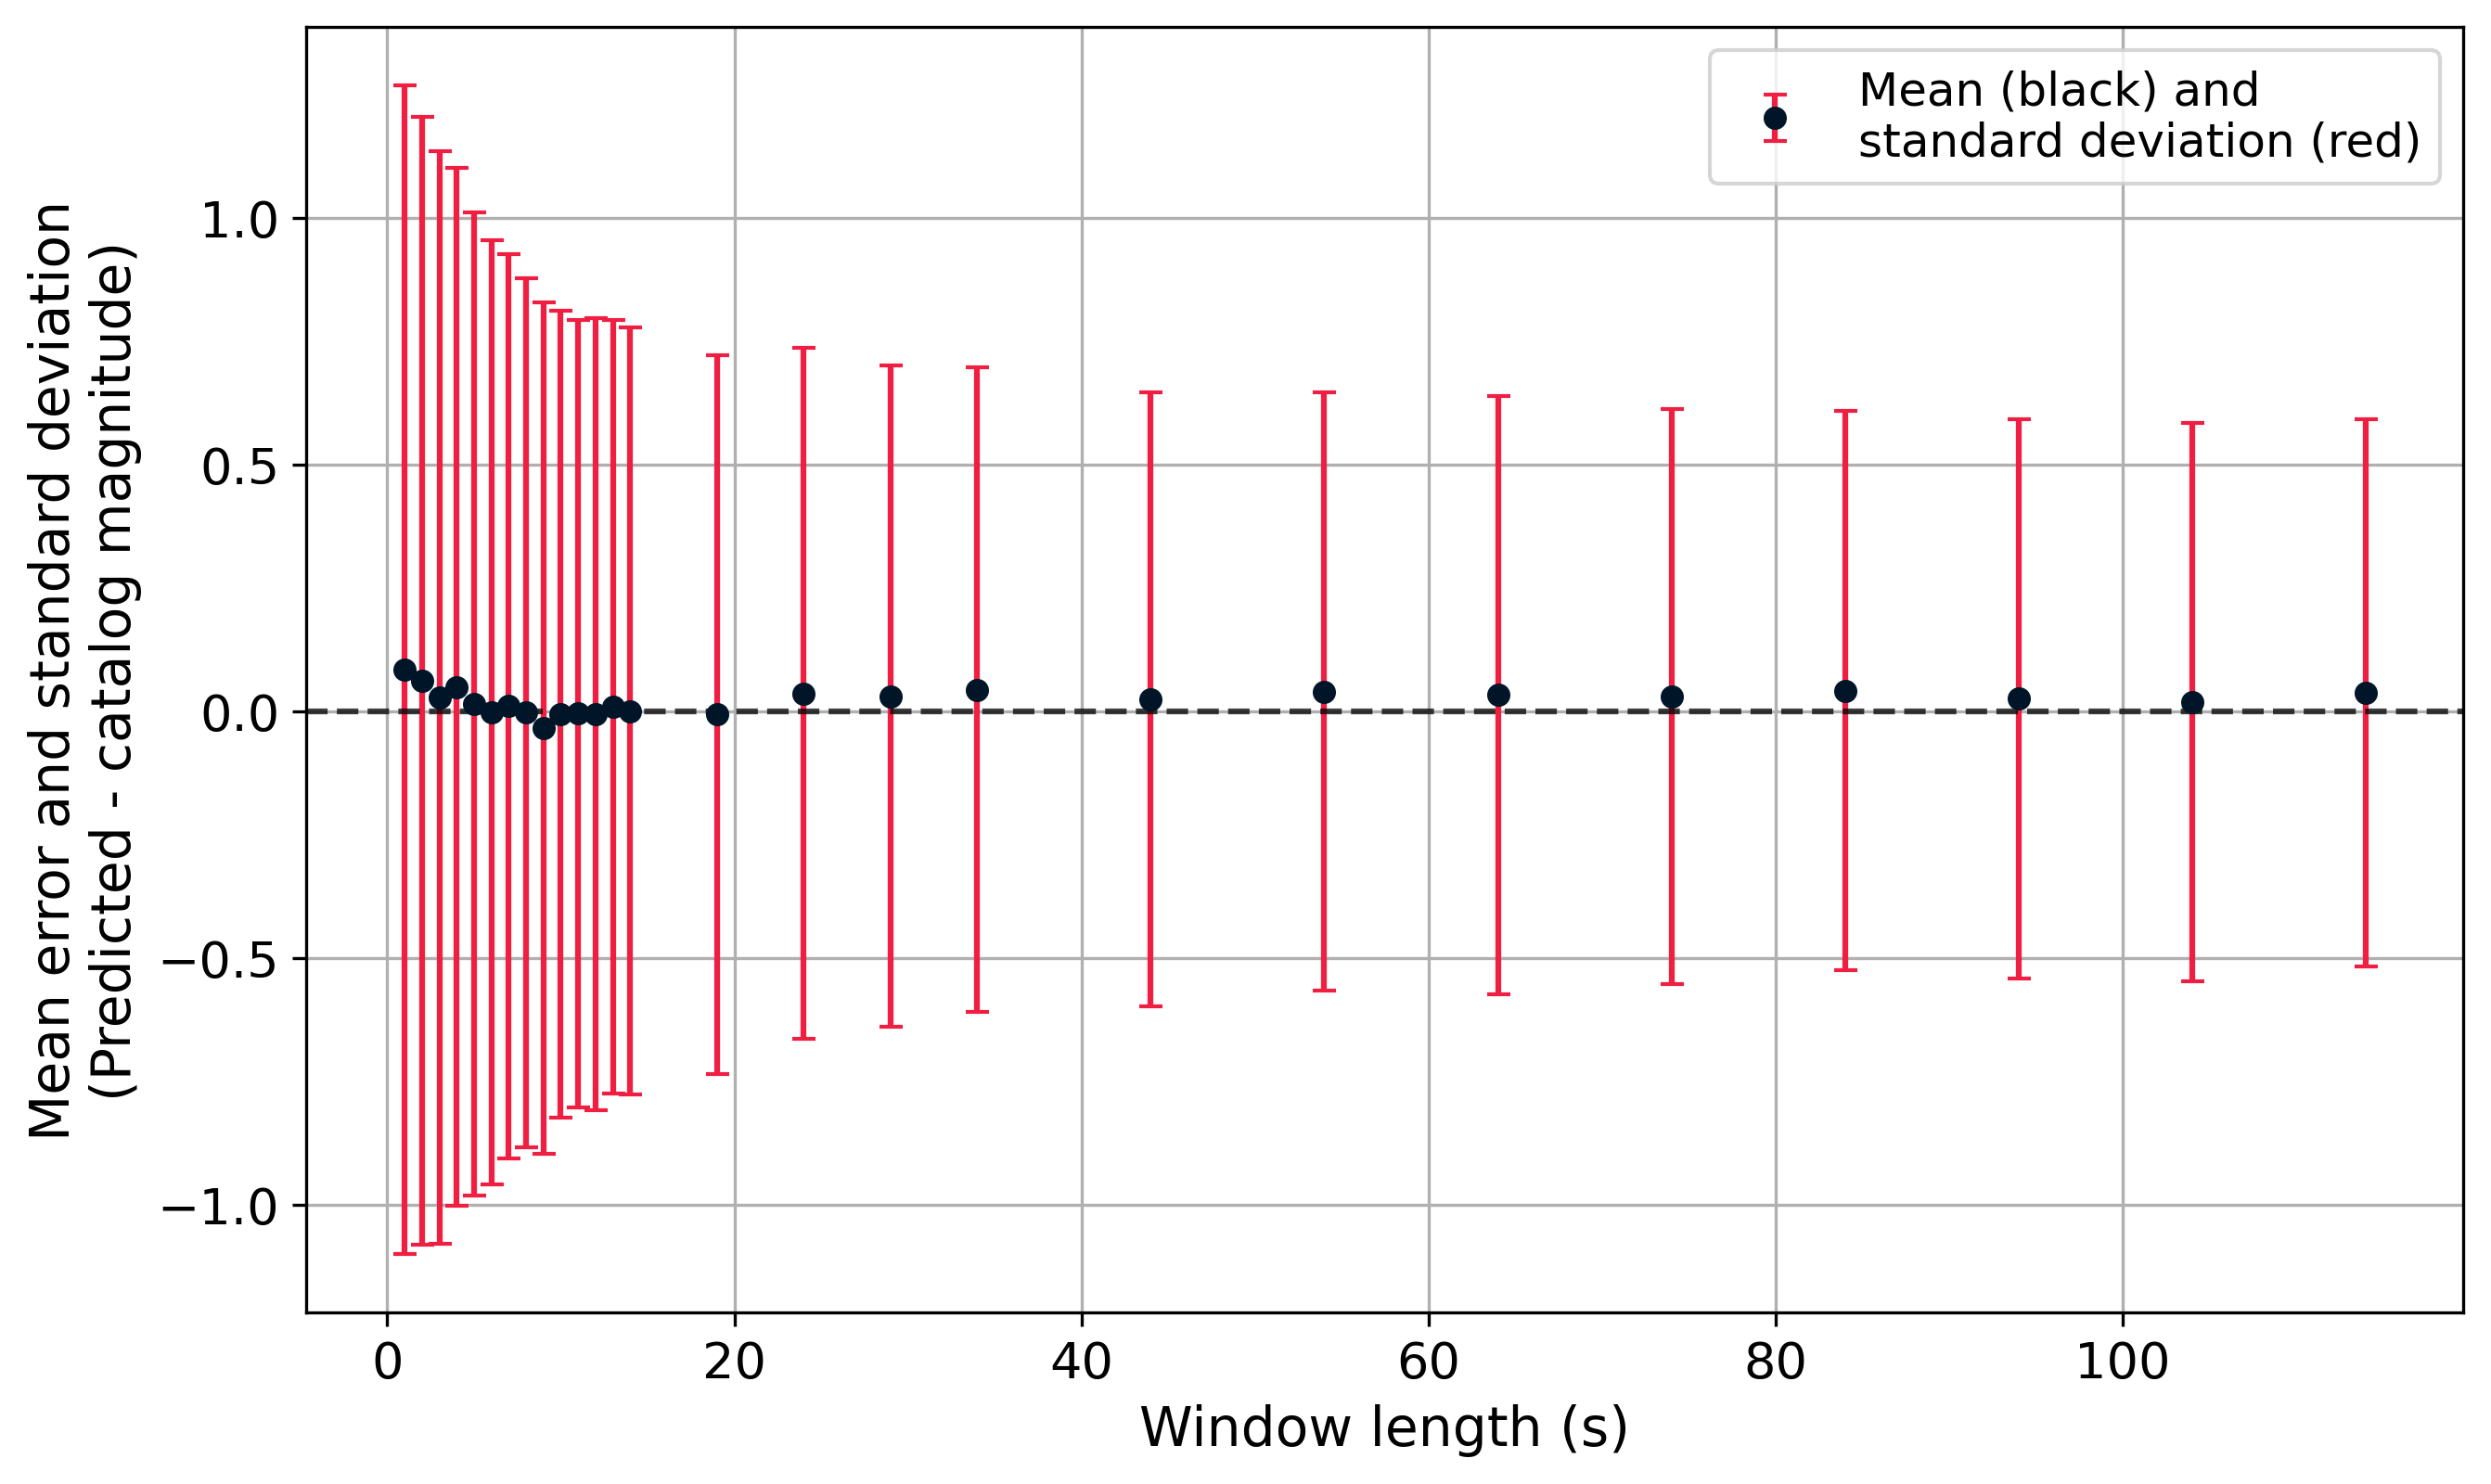

In [17]:
### ----- Plot error and std for all windows ----- ###

shift_lengths = []

for cut_len in cut_lens:
    shift_len = cut_len - max_shift
    shift_lengths.append(shift_len)
    
plt.figure(figsize = (10, 6), dpi = 300, facecolor = 'white')
# plt.title('Testing errors/stds: models trained with\n2.92 million augmented samples shifted up to 3 seconds', fontsize = 16)
plt.errorbar(shift_lengths, mean_errors, color = '#001528', yerr = std_errors, fmt = '.', markersize = 10, ecolor = '#f01f42', capsize = 3, label = 'Mean (black) and\nstandard deviation (red)')
# plt.scatter(shift_lengths, mean_errors, color = '#2DADB4')
plt.grid()
plt.xlabel('Window length (s)', fontsize = 14)
plt.ylabel('Mean error and standard deviation\n(Predicted - catalog magnitude)', fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 12)
plt.axhline(0, color = 'black', linestyle = '--', alpha = 0.75)

plt.show()
# plt.savefig('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/meanstderror_timeplot.png', format = 'PNG', facecolor = 'white', transparent = False)
# plt.close();

In [18]:
mean_errors = np.loadtxt('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/meanerrors.txt')
std_errors = np.loadtxt('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/stderrors.txt')

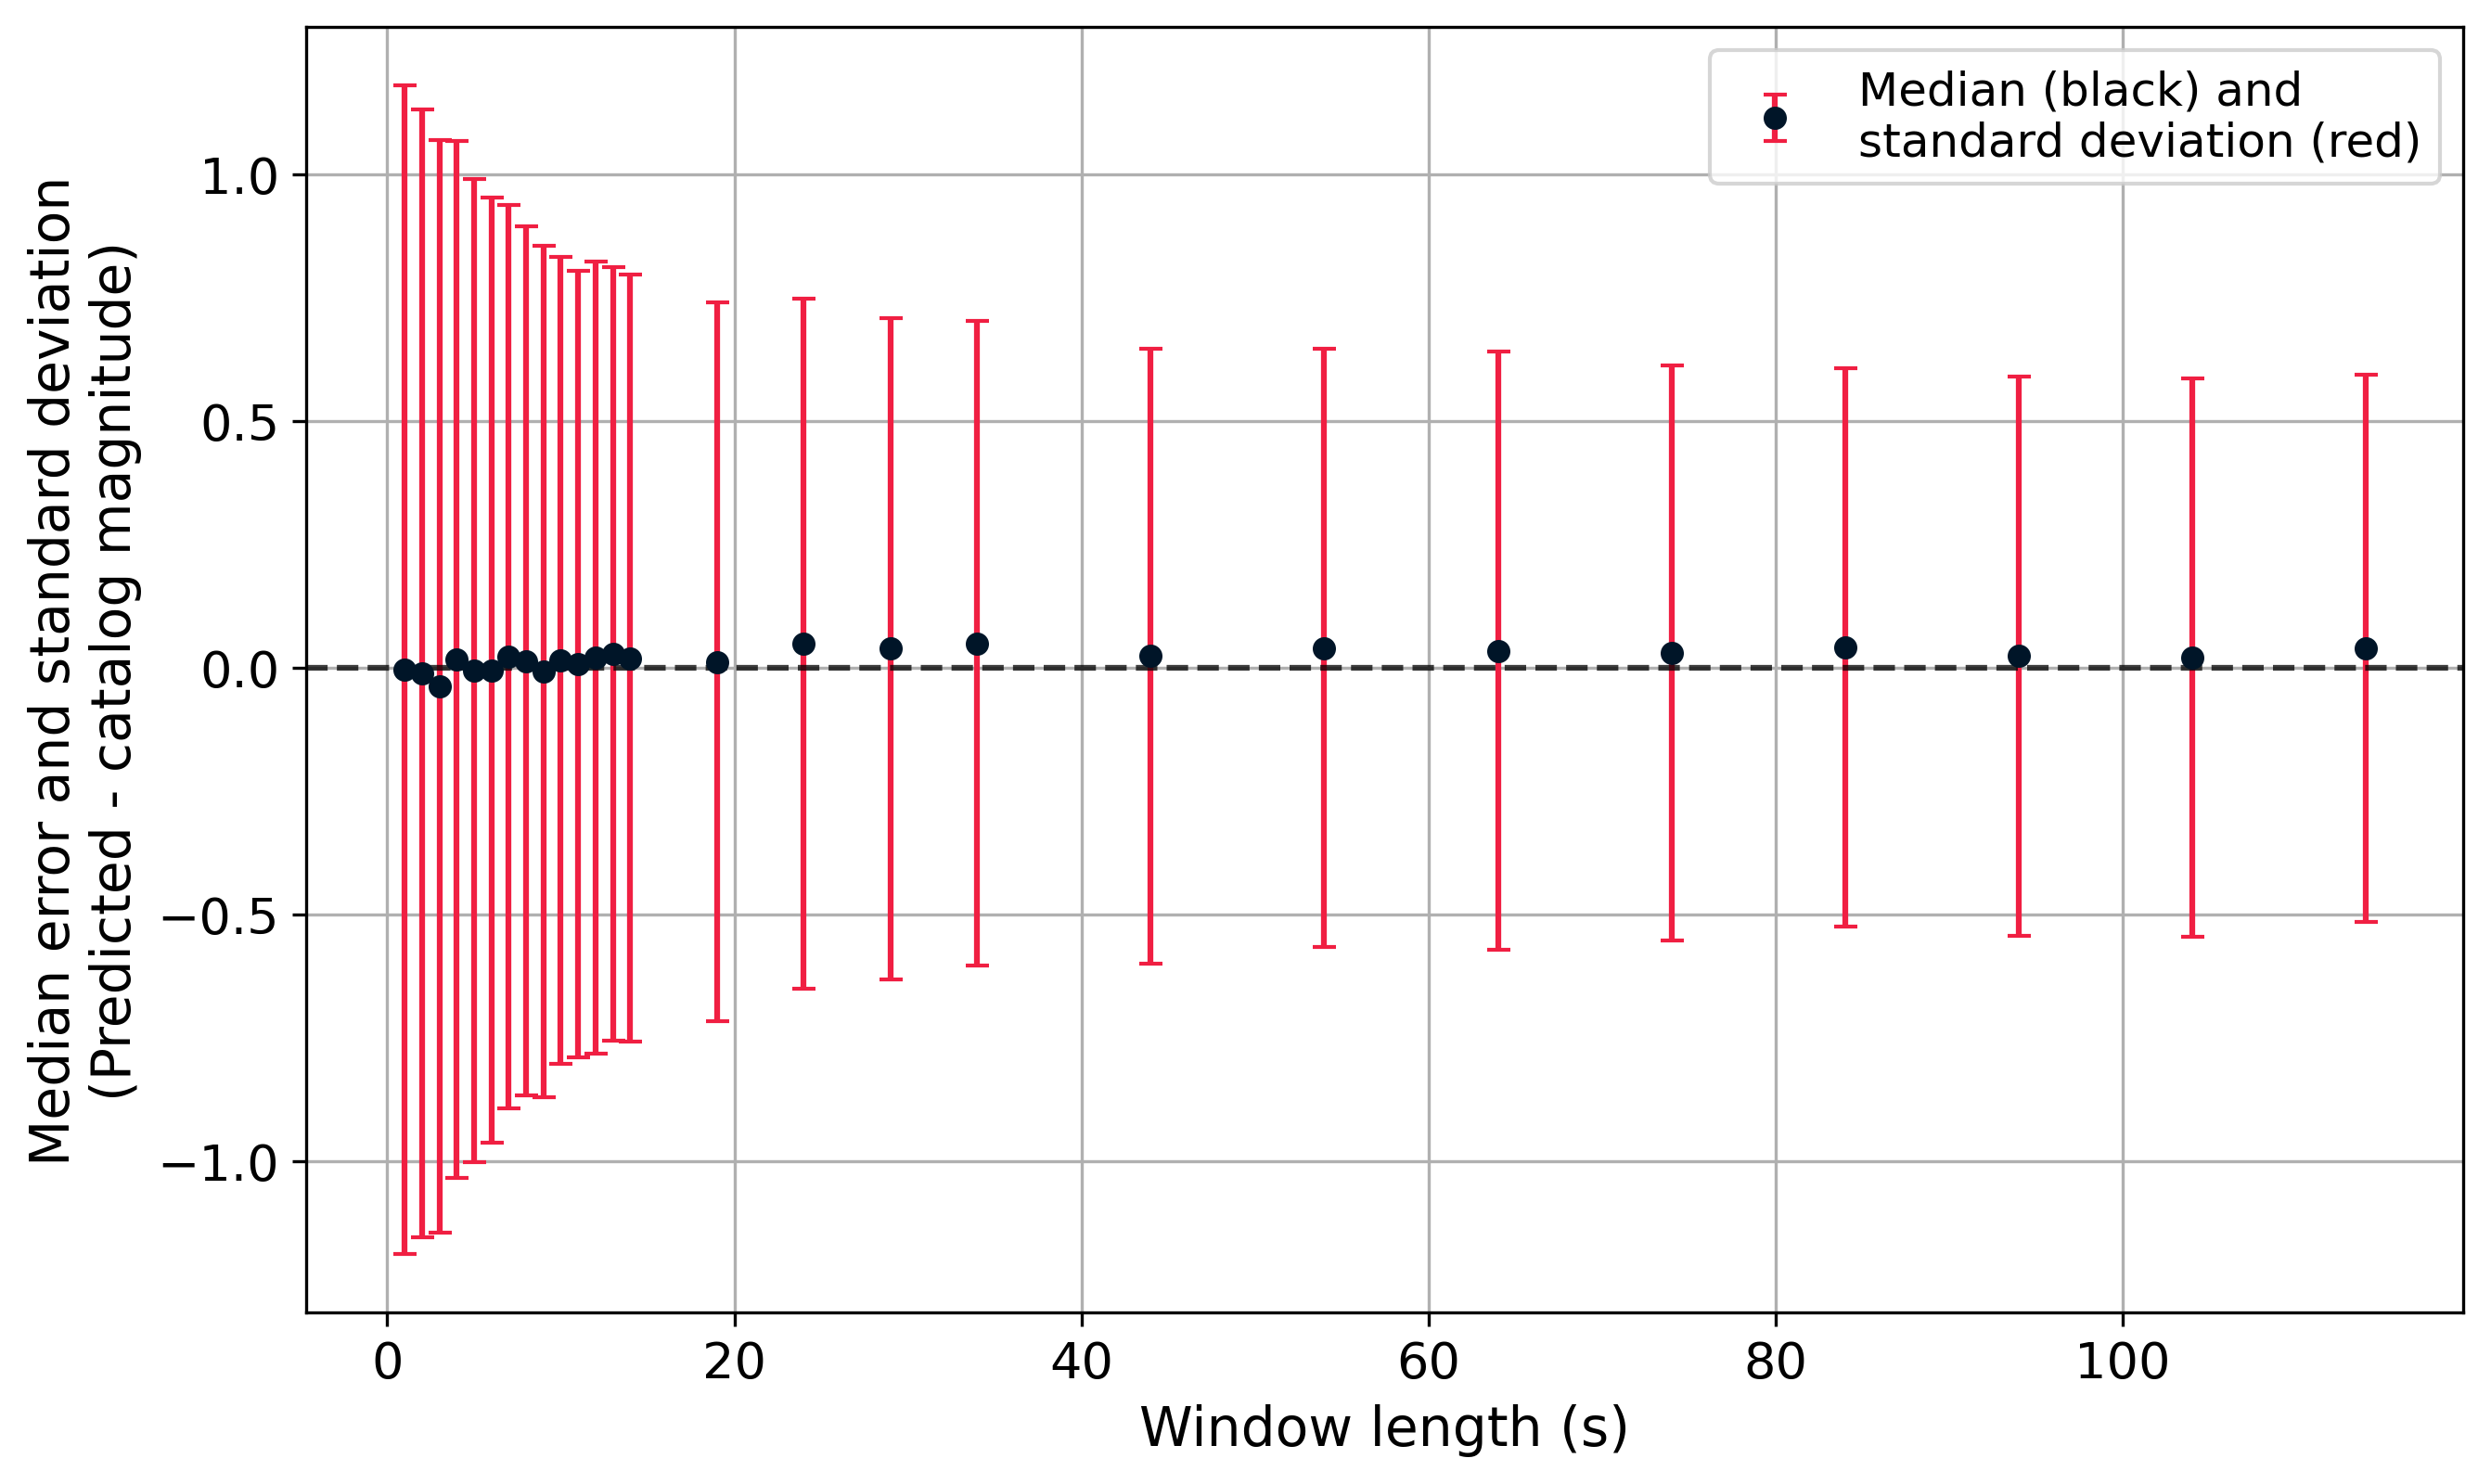

In [19]:
### ----- FIGURE 7 ----- ###

### ----- Plot error and std for all windows ----- ###

shift_lengths = []

for cut_len in cut_lens:
    shift_len = cut_len - max_shift
    shift_lengths.append(shift_len)
    
plt.figure(figsize = (10, 6), dpi = 300, facecolor = 'white')
# plt.title('Testing errors/stds: models trained with\n2.92 million augmented samples shifted up to 3 seconds', fontsize = 16)
plt.errorbar(shift_lengths, median_errors, color = '#001528', yerr = std_errors, fmt = '.', markersize = 10, ecolor = '#f01f42', capsize = 3, label = 'Median (black) and\nstandard deviation (red)')
# plt.scatter(shift_lengths, mean_errors, color = '#2DADB4')
plt.grid()
plt.xlabel('Window length (s)', fontsize = 14)
plt.ylabel('Median error and standard deviation\n(Predicted - catalog magnitude)', fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 12)
plt.axhline(0, color = 'black', linestyle = '--', alpha = 0.75)

plt.show()
# plt.savefig('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/medianstderror_timeplot.png', format = 'PNG', facecolor = 'white', transparent = False)
# plt.close();